In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [3]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
northsea = [-17, 20, 40, 70]

# Time series

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


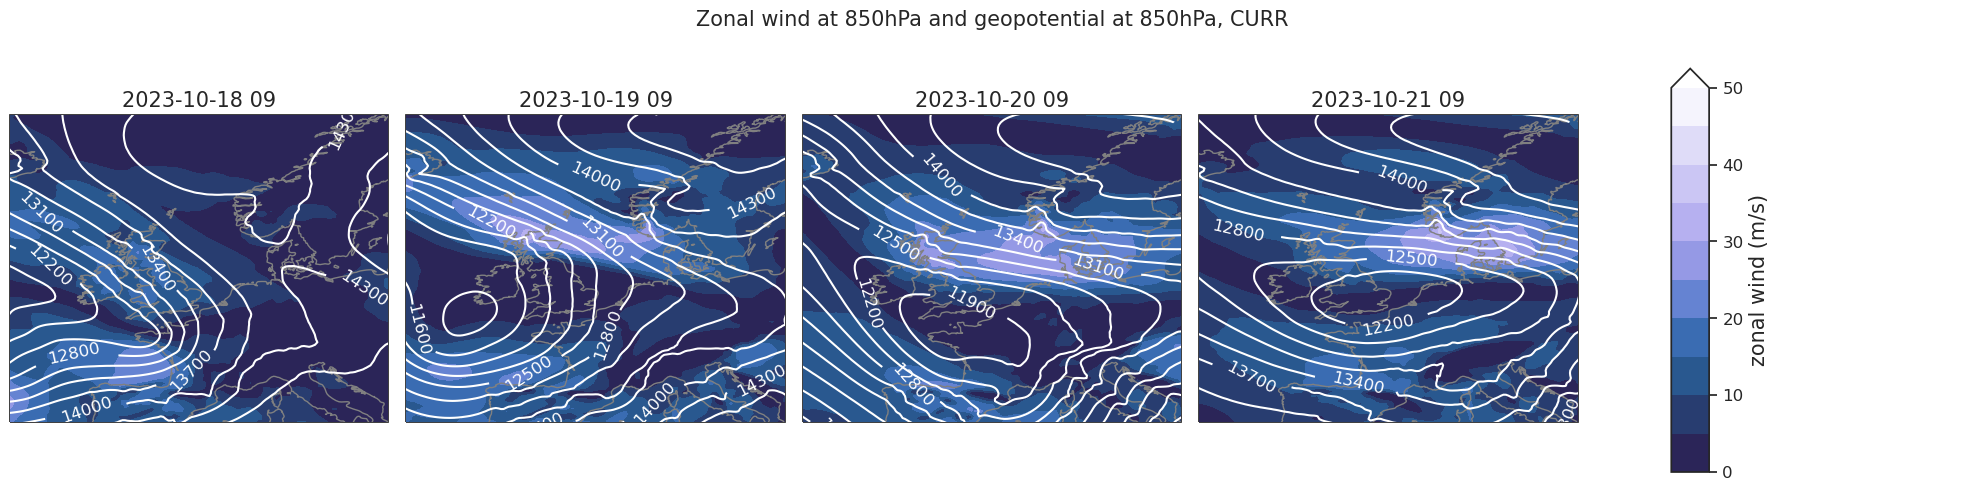

In [4]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09'] 
inidate = '2023-10-17' # TODO: change as needed
level_wind = 850

plt.figure(1, figsize=(20, 5)) 

speed_min = 0
speed_max = 50
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate=inidate).latitude.values
longitude = exp['curr'].sel(inidate=inidate).longitude.values

projection = ccrs.PlateCarree()
fs = 15

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        u_vals = exp['curr'].u.sel(inidate=inidate, time=t, level=level_wind).mean('number').squeeze().values
        v_vals = 0 #exp['curr'].v.sel(inidate=inidate, time=t, level=level_wind).mean('number').squeeze().values
        speed = np.sqrt(u_vals**2 + v_vals**2)

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(northsea, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        # ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
             transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_speed = np.linspace(speed_min, speed_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.devon,
                transform=projection, zorder = 10, extend = 'max')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = plt.colorbar(cf, cax=cax, label='zonal wind (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='zonal wind (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'PGW zonal wind at {level_wind}hPa and geopotential at 850hPa, CURR, inidate {inidate}', size = fs)
plt.tight_layout()

plt.savefig(f'../figures/A14_zonal_winds_{inidate}_curr_timeseries.png', dpi=600)
plt.savefig(f'../figures/A14_zonal_winds_{inidate}_curr_timeseries.pdf')   

# Comparison

In [ ]:
speed_min = -25
speed_max = 25
p_min = 11000
p_max = 15000
level_wind = 850

latitude = exp['curr'].sel(inidate=inidates[0]).latitude.values
longitude = exp['curr'].sel(inidate=inidates[0]).longitude.values

projection = ccrs.PlateCarree()
fs = 15 # fontsize

starttime = '2023-10-20 00' # same as in Vikki's analysis
endtime = '2023-10-21 00'

for inidate in inidates:
        fig = plt.figure(1, figsize=(20, 5)) 

        u_vals = exp['curr'].u.sel(inidate=inidate, time=slice(starttime, endtime), level=level_wind).mean(['number', 'time']).squeeze().values
        curr_speed = u_vals

        experiments = ['pi', 'curr', 'incr']
        for i, e in enumerate(experiments):
                if e in ['pi', 'incr']:
                        u_vals = exp[e].u.sel(inidate=inidate, time=slice(starttime, endtime), level=level_wind).mean(['number', 'time']).squeeze().values
                        speed = u_vals - curr_speed
                else:
                        speed = curr_speed

                ax = plt.subplot(1,4,i+1, projection=ccrs.PlateCarree())
                ax.set_extent(northsea, projection)
                ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

                if e in ['pi', 'incr']:
                        clevs_speed = np.linspace(-4, 4, 11)
                        cf_diff = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.bam,
                                transform=projection, zorder = 10, extend = 'both')
                else:
                        clevs_speed = np.linspace(speed_min, speed_max, 11)
                        cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.tofino,
                                transform=projection, zorder = 10, extend = 'max')

                plt.title(e, size=fs)

        ax = plt.subplot(1,4,4)
        ax.axis('off')  # removes subplot frame
        cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
        cbar = fig.colorbar(cf, cax=cax, label='Wind speed (m/s)', extend = 'both', shrink=0.8)
        cbar.set_label(label='Wind speed (m/s)', size=fs) 
        cbar.ax.tick_params(labelsize=fs-3)

        cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
        cbar = fig.colorbar(cf_diff, cax=cax_diff, label='Zonal wind difference (m/s)', extend = 'both', shrink=0.8)
        cbar.set_label(label='Zonal wind difference (m/s)', size=fs) 
        cbar.ax.tick_params(labelsize=fs-3)
        plt.suptitle(f'PGW zonal wind at {level_wind}hPa, init {inidate}', size = fs)
        plt.tight_layout()
        plt.show()

        plt.savefig(f'../figures/A14_zonal_winds_{inidate}_comparison.png', dpi=600)
        plt.savefig(f'../figures/A14_zonal_winds_{inidate}_comparison.pdf') 